In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR']) # เป็นdictionary

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [3]:
# Save the input and target variables

# print(diabetes_dataset.keys()) #ดู key เพื่อหาที่เก็บ data และ target

data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [ ]:
print(data.shape)
print(targets.shape)

In [4]:
# Normalise the target data (this will make clearer training curves)

# ลบค่า mean (เราสามารถ call mean method บน numpy array ได้เลย (กำหนด axis ด้วย))
# standard deviation ก็เช่นกัน
targets = (targets - targets.mean(axis=0)) / targets.std() 

In [ ]:
print(targets)

In [5]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data , test_data ,train_targets,test_targets  = train_test_split(data,targets,test_size = 0.1)

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

#### Train a feedforward neural network model

In [6]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model(input_shape): # input shape เป็น rank - 1 จาก shape จริง
    model = Sequential([
        Dense(128,activation = 'relu',input_shape = input_shape), 
        Dense(128,activation = 'relu'),
        Dense(128,activation = 'relu'),
        Dense(128,activation = 'relu'),
        Dense(128,activation = 'relu'),
        Dense(128,activation = 'relu'),
        Dense(1)
    ])
    return model

model = get_model((train_data.shape[1],)) # ไม่ต้องใส่ shape[0] (num sample)  เอาแค่ shape ของ feature

In [ ]:
# Print the model summary

model.summary()

In [ ]:
# Compile the model

model.compile(optimizer = 'adam',loss='mse',metrics=['mae'])

In [ ]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data,train_targets , epochs = 100,validation_split  = 0.15 , batch_size = 64 , verbose = 1)

In [ ]:
# Evaluate the model on the test set

model.evaluate(test_data,test_targets,verbose = 2) 

โมเดล overfit มากเพราะ data น้อย และ epoch เยอะ

#### Plot the learning curves

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [7]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [8]:
def get_regularised_model(wd, rate): # argument = weight decay และ dropout rate
    # Dropout rate เป็น keep_prob
    model = Sequential([
        Dense(128, activation="relu",kernel_regularizer = regularizers.l2(wd),input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128,  kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128,  kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128,  kernel_regularizer = regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

https://www.tensorflow.org/api_docs/python/tf/keras/regularizers เวอร์ชั่นใหม่จะใช้ .L2 ตัวใหญ่ 

In [ ]:
# Re-build the model with weight decay and dropout layers

model = get_regularised_model(1e-5, 0.3)

In [ ]:
# Compile the model

model.compile(optimizer = 'adam',loss='mse',metrics=['mae'])

In [ ]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data,train_targets , epochs = 100,validation_split  = 0.15 , batch_size = 64 , verbose = 1)

In [ ]:
# Evaluate the model on the test set

model.evaluate(test_data,test_targets,verbose = 2) 

#### Plot the learning curves

In [ ]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [ ]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback # import คลาสแม่

class TrainingCallback(Callback): # sub-class หรือสร้างคลาสใหม่โดยสืบทอด template มาจากคลาสแม่ เพื่อแก้ไขmethodต่างๆ ตามต้องการ
    
    # overide method ต่างๆ ตามต้องการ (ดู method ใน documentation)
    # argenment ที่ method ต่างๆ ต้องตรงกับ class แม่ Callback ส่วนใหญ่จะรับ log มาใช้งานต่างๆ
    # ค่า logs defalut เป็น None (เดี๋ยวจะถูก pass มา ตอนใช้งานจริง)
    def on_train_begin(self , logs=None):
        print("Starting Training....")
    
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}") # สามารถเอาหมายเลข epoch ที่ pass มาใช้งานได้
    
    def on_train_batch_begin(self , batch, logs=None): # สามารถเอาหมายเลข  batch ที่ pass มาใช้งานได้ 
        print(f"Training: Starting batch {batch}")
    
    def on_train_batch_end(self , batch, logs=None): # สามารถเอาหมายเลข  batch ที่ pass มาใช้งานได้ 
        print(f"Training: Finished batch {batch}")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}") # สามารถเอาหมายเลข epoch ที่ pass มาใช้งานได้
    
    def on_train_end(self , logs=None):
        print("Finished Training....")
        

class TestingCallback(Callback):  # สำหรับตอน evaluate
    
    def on_test_begin(self , logs=None):
        print("Starting Testing....")
    
    def on_test_batch_begin(self , batch, logs=None):
        print(f"Testing: Starting batch {batch}")
    
    def on_test_batch_end(self , batch, logs=None): 
        print(f"Testing: Finished batch {batch}")
    
    def on_test_end(self , logs=None):
        print("Finished Testing....")
        
class PreditctionCallback(Callback):  # สำหรับตอน predict
    
    def on_predict_begin(self , logs=None):
        print("Starting Predict....")
    
    def on_predict_batch_begin(self , batch, logs=None):
        print(f"Predict: Starting batch {batch}")
    
    def on_predict_batch_end(self , batch, logs=None): 
        print(f"Predict: Finished batch {batch}")
    
    def on_predict_end(self , logs=None):
        print("Finished Predict....")

In [ ]:
# Re-build the model

model = get_regularised_model(1e-5, 0.3)

In [ ]:
# Compile the model

model.compile(optimizer = 'adam',loss='mse')

#### Train the model with the callback

In [ ]:
# Declare Callbacks

trainCallback = TrainingCallback()
testCallback =  TestingCallback()
predictCallback =  PreditctionCallback()

In [ ]:
# Train the model, with some of the data reserved for validation

# ใช้ traing callback กับ fit method
history = model.fit(train_data,train_targets , epochs = 3 , batch_size = 128 , verbose = False, callbacks =[trainCallback]) # verbose = False ปิดการแสดงผลทั้งหมด
# จะโชว์แค่ callbacks ของเรา

In [ ]:
# Evaluate the model

model.evaluate(test_data, test_targets , callbacks = [testCallback],verbose = False)

In [ ]:
# Make predictions with the model

model.predict(test_data, callbacks = [predictCallback],verbose = False)

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [21]:
# Declare Earlystopping Callback
earlystop = tf.keras.callbacks.EarlyStopping(patience=2)

In [22]:
# Re-train the unregularised model

unregularised_model =  get_model((train_data.shape[1],))
unregularised_model.compile(optimizer = 'adam',loss='mse')
unreg_history  = unregularised_model.fit(train_data,train_targets , epochs = 100,validation_split  = 0.15 , batch_size = 64 , verbose = False,callbacks =[earlystop])

In [11]:
# Evaluate the model on the test set

unregularised_model.evaluate(test_data,test_targets,verbose = 2)

45/1 - 0s - loss: 0.4534


0.4886977129512363

In [23]:
# Re-train the regularised model

regularised_model  = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer = 'adam',loss='mse')
reg_history  = regularised_model.fit(train_data,train_targets , epochs = 100,validation_split  = 0.15 , batch_size = 64 , verbose = False,callbacks =[earlystop])

In [13]:
# Evaluate the model on the test set

regularised_model.evaluate(test_data,test_targets,verbose = 2)

45/1 - 0s - loss: 0.3740


0.44963258306185405

#### Plot the learning curves

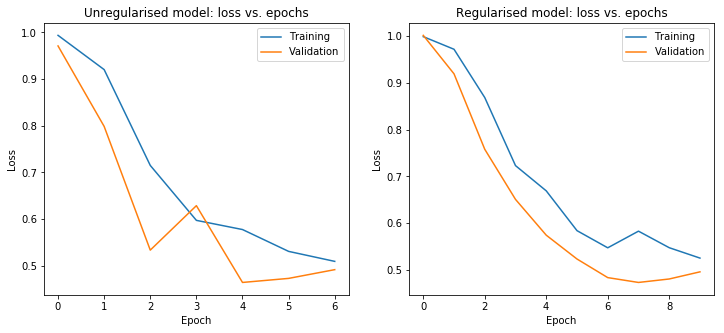

In [24]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()